In [1]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
import warnings

warnings.filterwarnings('ignore')
sns.set()

### Using scenario 10, as requested.

In [2]:
DATA_PATH_ORIG = r'../data/scenario_10.csv'

## IMPORTANT     
### The data has been processed using the preprocessing notebook. 

Read the data

In [3]:
data_df = pd.read_csv(DATA_PATH_ORIG, parse_dates=['start_date'])

In [4]:
data_df.head(5)

,start_date,duration,protocol,src_addr,dst_addr,flags,tos,packets,bytes,flows,label,src_port,dst_port
0,2011-08-18 10:19:13.328,0.002,TCP,147.32.86.166,212.24.150.110,FRPA_,0,4,321,1,Background,33426,25443
1,2011-08-18 10:19:13.328,4.995,UDP,82.39.2.249,147.32.84.59,INT,0,617,40095,1,Background,41915,43087
2,2011-08-18 10:19:13.329,4.996,UDP,147.32.84.59,82.39.2.249,INT,0,1290,1909200,1,Background,43087,41915
3,2011-08-18 10:19:13.330,0.000,TCP,147.32.86.166,147.32.192.34,A_,0,1,66,1,Background,42020,993
4,2011-08-18 10:19:13.330,0.000,TCP,212.24.150.110,147.32.86.166,FPA_,0,2,169,1,Background,25443,33426


In [5]:
data_df.shape

(5180851, 13)

In [7]:
data_df.dtypes

start_date    datetime64[ns]
duration             float64
protocol              object
src_addr              object
dst_addr              object
flags                 object
tos                    int64
packets                int64
bytes                  int64
flows                  int64
label                 object
src_port               int64
dst_port               int64
dtype: object

Have a look at the labels we have

In [8]:
data_df['label'].unique()

array(['Background', 'LEGITIMATE', 'Botnet'], dtype=object)

Let's remove the background flows, as stated in the assignment.

In [9]:
data_df = data_df[data_df['label'] != 'Background']
data_df.reset_index(drop=True, inplace=True)
data_df.shape

(645358, 13)

In [10]:
data_df.describe()

,duration,tos,packets,bytes,flows,src_port,dst_port
count,645358.000000,645358.0,645358.000000,6.453580e+05,645358.0,645358.000000,645358.000000
mean,0.628303,0.0,17.501906,1.347261e+04,1.0,17611.881387,2253.085055
std,1.399230,0.0,123.108174,1.337652e+05,0.0,24020.915199,9634.422329
min,0.000000,0.0,1.000000,6.000000e+01,1.0,-1.000000,-1.000000
25%,0.000000,0.0,1.000000,2.610000e+02,1.0,-1.000000,-1.000000
50%,0.000000,0.0,1.000000,1.066000e+03,1.0,80.000000,53.000000
75%,0.222000,0.0,4.000000,1.306000e+03,1.0,45499.000000,443.000000
max,22.581000,0.0,16937.000000,2.497247e+07,1.0,65535.000000,65530.000000


## Data investigation to find two features to use

In [11]:
def subset_data_by_host(all_data, host_ip):
    sub_df = all_data[
        (all_data['src_addr'] == host_ip) 
        | 
        (all_data['dst_addr'] == host_ip)
    ]
    sub_df.reset_index(drop=True, inplace=True)
    return sub_df

We need to select one infected host and investigate the data. We select '147.32.84.165' by looking at the documentation of scenario 10.

In [15]:
infected_host_ip = '147.32.84.165' # taken from website
not_infected_host_ip = '147.32.84.170' # taken from website

inf_data = subset_data_by_host(data_df, infected_host_ip)
non_inf_data = subset_data_by_host(data_df, not_infected_host_ip)

print(f"Infected Data: {inf_data.shape[0]} connections with infected host '{infected_host_ip}' found.")
print(f"Infected Data: {non_inf_data.shape[0]} connections with normal host '{not_infected_host_ip}' found.")

print(inf_data.label.unique())
print(non_inf_data.label.unique())

Infected Data: 29526 connections with infected host '147.32.84.165' found.
Infected Data: 20980 connections with normal host '147.32.84.170' found.
['Botnet']
['LEGITIMATE']


Compute milliseconds between connections, per host

In [17]:
def compute_deltas(data):
    return (data['start_date']-data['start_date'].shift()).fillna(0).values.astype(np.int64) // 10 ** 6

In [18]:
inf_data['delta'] = compute_deltas(inf_data)
non_inf_data['delta'] = compute_deltas(non_inf_data)

Let's inspect how these deltas look like

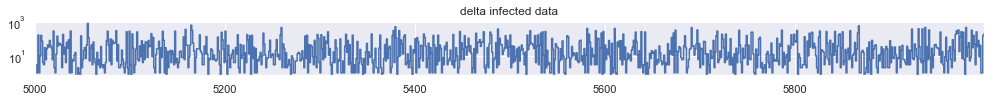

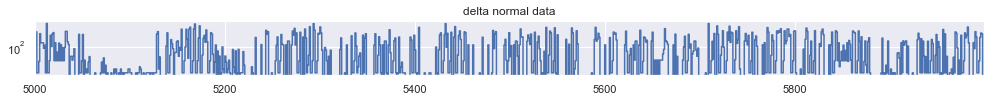

In [23]:
start = 5000
stop = 6000

inf_data['delta'].iloc[start:stop].plot(figsize=(17,1), drawstyle='steps-post')
plt.yscale("log")
plt.title("delta infected data")
plt.show()

non_inf_data['delta'].iloc[start:stop].plot(figsize=(17,1), drawstyle='steps-post')
plt.yscale("log")
plt.title("delta normal data")
plt.show()

INFECTED


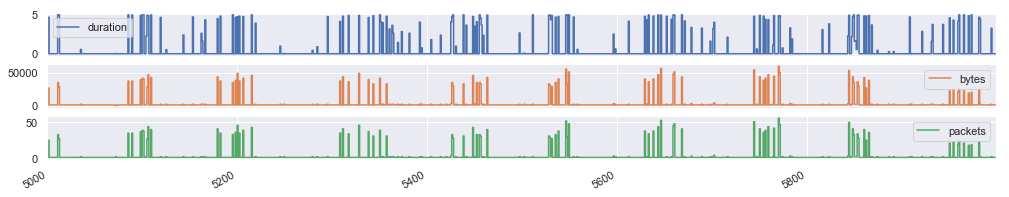

In [24]:
print("INFECTED")
inf_data[['duration', 'bytes', 'packets']].iloc[start:stop].plot(figsize=(17,3*1), subplots=True, drawstyle='steps-post')
plt.show()

NORMAL


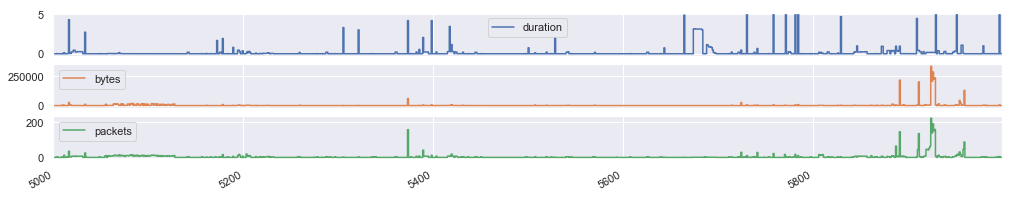

In [25]:
print("NORMAL")
non_inf_data[['duration', 'bytes', 'packets']].iloc[start:stop].plot(figsize=(17,3*1), subplots=True, drawstyle='steps-post')
plt.show()

### Selected features: duration, packets

Using the features we selected with the analysis above, we perform the discretization on the full data.

In [26]:
feat_df = data_df[['duration', 'packets']]

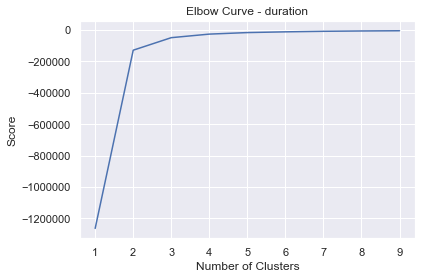

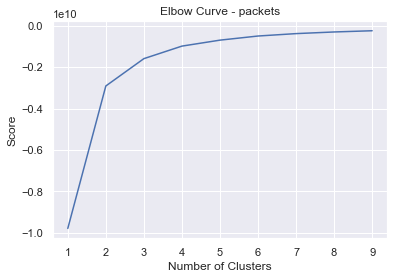

In [334]:
for feat in feat_df.columns:
    Nc = range(1, 10)
    kmeans = [KMeans(n_clusters=i) for i in Nc]
    data = feat_df[feat].values.reshape(-1, 1)
    score = [kmeans[i].fit(data).score(data) for i in range(len(kmeans))]
    plt.plot(Nc,score)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    plt.title(f'Elbow Curve - {feat}')
    plt.show()

By looking at the ELBOW plots, we find the optimal number of clusters for each numerical feature    
We then manually select the percentiles in order to visually see that the discretization was capturing the behaviour and, at the same time, showing differences between infected and normal hosts

Let's start by looking at duration feature

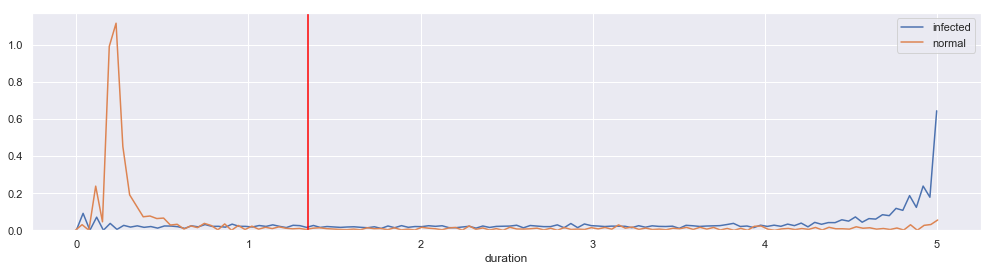

In [407]:
inf_duration = subset_data_by_host(data_df, infected_host_ip)['duration']
not_inf_duration = subset_data_by_host(data_df, not_infected_host_ip)['duration']
all_duration = data_df['duration']

plt.figure(figsize=(17,4))
sns.distplot(inf_duration, hist=False, label='infected')
sns.distplot(not_inf_duration, hist=False, label='normal')
plt.axvline(np.percentile(all_duration, 85), color='red') # tried different percentiles in order to have a good cut
plt.legend()
plt.show()

Let's now look at packets

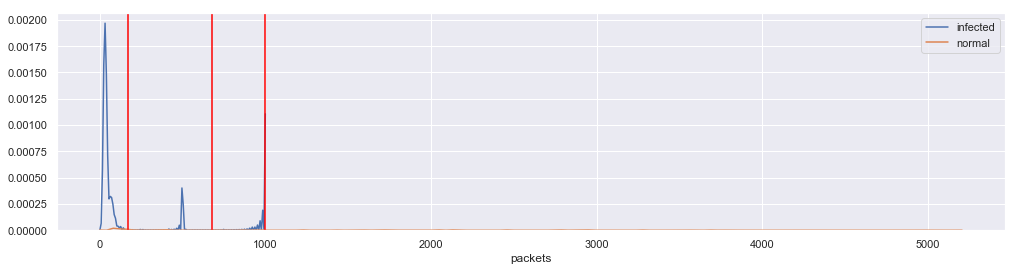

In [411]:
inf_packets = subset_data_by_host(data_df, infected_host_ip)['packets']
not_inf_packets = subset_data_by_host(data_df, not_infected_host_ip)['packets']
all_packets = data_df['packets']

plt.figure(figsize=(17,4))
sns.distplot(inf_packets, hist=False, label='infected')
sns.distplot(not_inf_packets, hist=False, label='normal')
plt.axvline(np.percentile(all_packets, 98.5), color='red') # tried different percentiles in order to have a good cut
plt.axvline(np.percentile(all_packets, 99.2), color='red') # tried different percentiles in order to have a good cut
plt.axvline(np.percentile(all_packets, 99.5), color='red') # tried different percentiles in order to have a good cut
plt.legend()
plt.show()

In [436]:
# clust_values = {
#     'duration': [70, 90], #correct
#     'packets': [35, 65, 80]
# }

# values 
clust_values = {
    'duration': [85],
    'packets': [98.5, 99.2, 99.5]
}

In [437]:
def get_indices(percentiles,values):
    breaks = []
    for p in percentiles:
        breaks.append(np.percentile(values,p))
    return breaks

def mapping(values, percentiles):    
    breakpoints = get_indices(percentiles, values)
    print(breakpoints)
    new_values = []
    for value in values:
        for index, breakpoint in enumerate(breakpoints):
            if breakpoint >= value:
                new_values.append(index)
                break
        else:
            new_values.append(len(breakpoints))
    return new_values

def mapping_v2(series, n_clusters):   
    kmeans = KMeans(n_clusters=n_clusters).fit(series.values.reshape(-1, 1))
    return kmeans.labels_

Let's create the data with the two chosen features: duration and packets

In [438]:
discretized_df = pd.DataFrame(
    {
        'duration': mapping(feat_df['duration'], clust_values['duration']),
        'packets': mapping(feat_df['packets'], clust_values['packets']),
    }
)

# discretized_df = pd.DataFrame(
#     {
#         'duration': mapping_v2(feat_df['duration'], clust_values['duration']),
#         'packets': mapping_v2(feat_df['packets'], clust_values['packets']),
#     }
# )

[1.348]
[169.0, 680.1439999999711, 1000.0]


In [439]:
discretized_df.head()

,duration,packets
0,1,0
1,0,0
2,1,0
3,1,0
4,0,0


FULL DATA (no background) BEFORE AND AFTER DISCRETIZATION


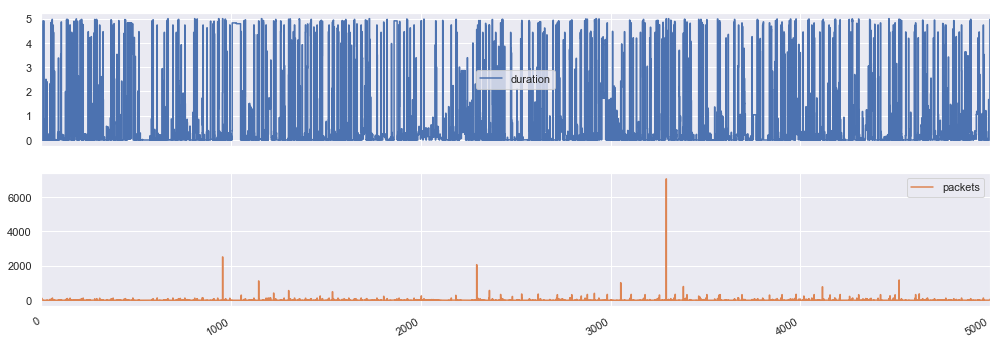

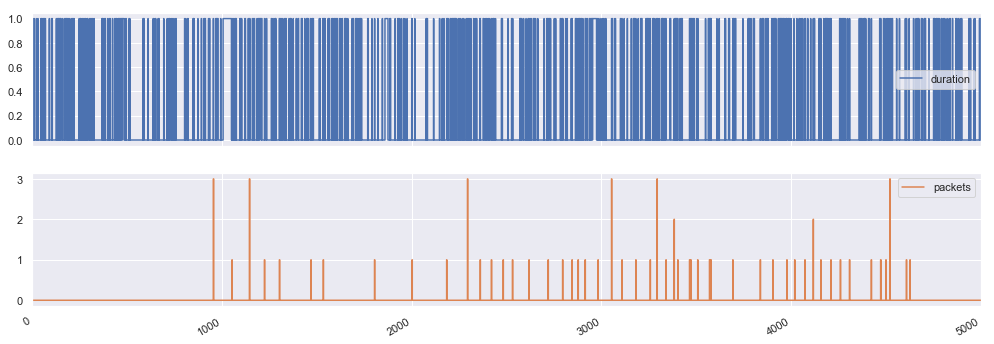

In [440]:
print("FULL DATA (no background) BEFORE AND AFTER DISCRETIZATION")
start = 0
stop = 5000
data_df[['duration', 'packets']].iloc[start:stop].plot(figsize=(17, 6), subplots=True, drawstyle='steps')
plt.show()

discretized_df.iloc[start:stop].plot(figsize=(17, 6), subplots=True, drawstyle='steps')
plt.show()

## Check if there is a difference between infected and not infected also after discretization

Infected Data: 29526 connections with infected host '147.32.84.165' found.
Infected Data: 20980 connections with normal host '147.32.84.170' found.
INFECTED


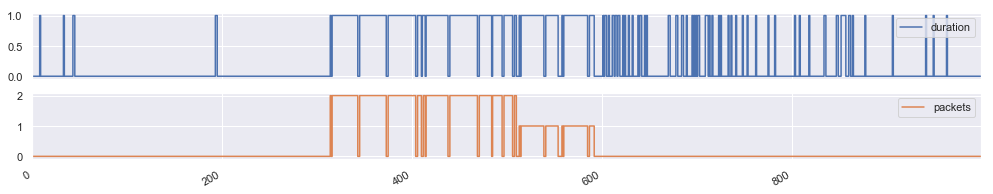

NON INFECTED


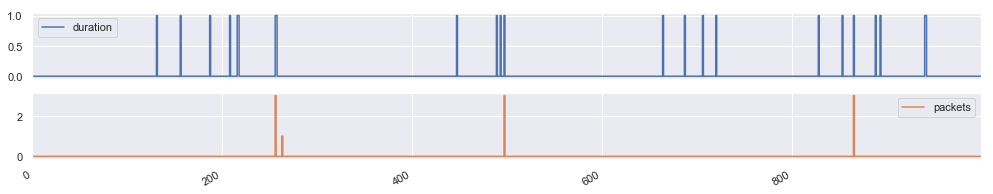

In [441]:
temp_df = pd.concat([discretized_df, data_df[['src_addr', 'dst_addr']]], axis=1)

infected_host_ip = '147.32.84.165'
not_infected_host_ip = '147.32.84.170'

temp_inf = subset_data_by_host(temp_df, infected_host_ip)
temp_non_inf = subset_data_by_host(temp_df, not_infected_host_ip)

print(f"Infected Data: {temp_inf.shape[0]} connections with infected host '{infected_host_ip}' found.")
print(f"Infected Data: {temp_non_inf.shape[0]} connections with normal host '{not_infected_host_ip}' found.")

start = 0
stop = 1000

print("INFECTED")
temp_inf[['duration', 'packets']].iloc[start:stop].plot(figsize=(17,3*1), subplots=True, drawstyle='steps-post')
plt.show()
print("NON INFECTED")
temp_non_inf[['duration', 'packets']].iloc[start:stop].plot(figsize=(17,3*1), subplots=True, drawstyle='steps-post')
plt.show()

In [442]:
from functools import reduce
def get_code(data_df):
    uniques = {col:data_df[col].nunique() for col in data_df.columns}
    num_of_elems_per_feat = [uniques[name] for name in uniques]
    codes = []
    for idx, row in data_df.iterrows():
        code = 0
        space_size = reduce(lambda x,y: x*y, num_of_elems_per_feat, 1)
        
        for col in data_df.columns:
            code += row[col] * space_size / uniques[col]
            space_size /= uniques[col]
        codes.append(code)
    
    return pd.Series(codes).astype(int)

In [443]:
coded_df = get_code(discretized_df)

In [444]:
coded_df = pd.DataFrame({'code': coded_df})

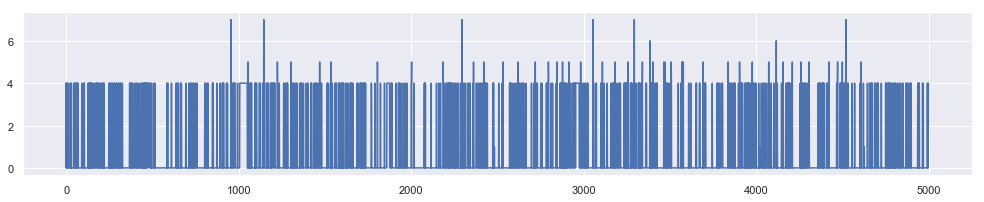

In [445]:
plt.figure(figsize=(17, 3))
plt.plot(coded_df[:5000])
plt.show()

## See if there is a difference between infected and normal in the coded signal

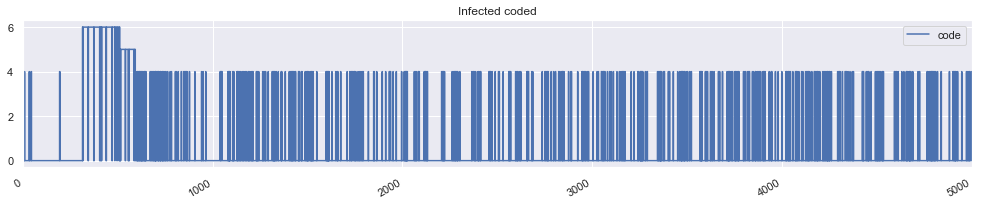

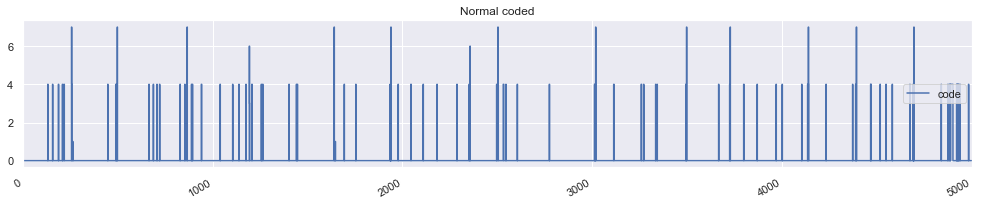

In [446]:
columns_to_show = ['code']
start = 0
stop = 5000

temp_df = pd.concat([coded_df, data_df[['src_addr', 'dst_addr']]], axis=1)

infected_host_ip = '147.32.84.165'
not_infected_host_ip = '147.32.84.170'

temp_inf = subset_data_by_host(temp_df, infected_host_ip)
temp_non_inf = subset_data_by_host(temp_df, not_infected_host_ip)

temp_inf[columns_to_show].iloc[start:stop].plot(figsize=(17,3*1), subplots=True, drawstyle='steps-post')
plt.title("Infected coded")
plt.show()

temp_non_inf[columns_to_show].iloc[start:stop].plot(figsize=(17,3*1), subplots=True, drawstyle='steps-post')
plt.title("Normal coded")
plt.show()

# BOTNET PROFILING TASK

We start by implementing the sliding window approach. What we get out of this is, per infected host, a list of the list of connections taking place in the defined window.

In [447]:
full_data_df = pd.DataFrame({
    'code': coded_df['code'].values, 
    'start_date': data_df['start_date'],
    'src_addr': data_df['src_addr'].values,
    'dst_addr': data_df['dst_addr'].values,
})
full_data_df.head()

,code,start_date,src_addr,dst_addr
0,4,2011-08-18 10:19:13.347,147.32.80.13,147.32.85.88
1,0,2011-08-18 10:19:13.392,147.32.86.110,74.125.232.214
2,4,2011-08-18 10:19:13.411,147.32.85.88,147.32.80.13
3,4,2011-08-18 10:19:13.460,147.32.84.59,74.125.108.208
4,0,2011-08-18 10:19:13.486,147.32.84.59,74.125.232.215


Let's filter on one infected host. This is the guy we are going to use to model the HMM

In [448]:
def get_state_sliding_window(host_data, window_width):
    states = []
    
    delta_series = host_data['delta'].values
    code_series = host_data['code'].values
    
    for row_index in range(0, host_data.shape[0]):
        current_row = row_index
        
        window_deltas = 0
        
        try:
            while window_deltas <= window_width:
                current_row += 1
                window_deltas += delta_series[current_row]
                
        except:
            break
            
        current_row -= 1
        
        states.append(list(code_series[row_index:current_row]))
   
    return [lst for lst in states if lst]

# HMMs

In [449]:
from hmmlearn.hmm import GaussianHMM

In [450]:
def get_likelihood_for_host(all_data, host_ip, window_width, hmm_model, filter_value):
    
    # filter
    host_data = subset_data_by_host(all_data, host_ip)
    
    # compute deltas for the host
    host_data['delta'] = compute_deltas(host_data)
    
    # apply sliding window
    extracted_states = get_state_sliding_window(host_data[['code', 'delta']], window_width)
    cleaned_normal_states = [states for states in extracted_states if len(states)>=filter_value]
    
    # reshape the data for HMM library
    X_flat = [item for sublist in cleaned_normal_states for item in sublist]
    
    if not X_flat:
        print(f"'{host_ip}' has no data")
        return
    
    X_flat = np.array(X_flat).reshape(-1,1)
    score = model.decode(X_flat)[0]
    return score

Test on remaining hosts

In [451]:
hosts = {
    "train": "147.32.84.165",
    "infected": [
        "147.32.84.191", 
        "147.32.84.192", 
        "147.32.84.193",
        "147.32.84.204",
        "147.32.84.205",
        "147.32.84.206",
        "147.32.84.207",
        "147.32.84.208",
        "147.32.84.209"
    ],
    "normal": [
        "147.32.84.170",
        "147.32.84.134",
        "147.32.84.164",
        "147.32.87.36",
        "147.32.80.9",
        "147.32.87.11"
    ],    
}

In [452]:
log_probs = {}

First of all, let's learn the HMM on the training host (infected)

In [453]:
win_length = 20
n_of_states = 2
MAGIC_NUMBER_TO_FILTER_OUT_STATES = 1

In [454]:
train_host = hosts['train']

filtered_data_modeling = subset_data_by_host(full_data_df, train_host)
filtered_data_modeling['delta'] = compute_deltas(filtered_data_modeling)
modeling_data = filtered_data_modeling[['code', 'delta']]

training_states = get_state_sliding_window(modeling_data, win_length)
training_states = [states for states in training_states if len(states)>=MAGIC_NUMBER_TO_FILTER_OUT_STATES]

print(f"Training the model on {len(training_states)} sequences")

Training the model on 17723 sequences


In [455]:
X_flat = [item for sublist in training_states for item in sublist]
lengths = [len(states) for states in training_states]
X_flat = np.array(X_flat).reshape(-1,1)

model = GaussianHMM(n_components=n_of_states).fit(X_flat, lengths=lengths)

log_probs['train'] = model.decode(X_flat)[0]

Now, let's test the obtained model on the remaining hosts

In [456]:
infected_probs = {}
for host in hosts['infected']:
    print(f"Processing host '{host}'")
    infected_probs[host] = get_likelihood_for_host(full_data_df, host, win_length, model, MAGIC_NUMBER_TO_FILTER_OUT_STATES)
log_probs['infected'] = infected_probs

normal_probs = {}
for host in hosts['normal']:
    print(f"Processing host '{host}'")
    lprob = get_likelihood_for_host(full_data_df, host, win_length, model, MAGIC_NUMBER_TO_FILTER_OUT_STATES)
    if lprob:
        normal_probs[host] = lprob
    else:
        print(f"Cannot process host '{host}'")
        
log_probs['normal'] = normal_probs

Processing host '147.32.84.191'
Processing host '147.32.84.192'
Processing host '147.32.84.193'
Processing host '147.32.84.204'
Processing host '147.32.84.205'
Processing host '147.32.84.206'
Processing host '147.32.84.207'
Processing host '147.32.84.208'
Processing host '147.32.84.209'
Processing host '147.32.84.170'
Processing host '147.32.84.134'
Processing host '147.32.84.164'
Processing host '147.32.87.36'
Processing host '147.32.80.9'
Processing host '147.32.87.11'
'147.32.87.11' has no data
Cannot process host '147.32.87.11'


In [457]:
log_probs

{'train': 366477.93266459426,
 'infected': {'147.32.84.191': 411563.21099922707,
  '147.32.84.192': 410862.5400717686,
  '147.32.84.193': 437472.3067218273,
  '147.32.84.204': 430580.23395519337,
  '147.32.84.205': 455115.39773467975,
  '147.32.84.206': 432420.5436347334,
  '147.32.84.207': 456786.1368535886,
  '147.32.84.208': 399507.8093453985,
  '147.32.84.209': 409377.53032622335},
 'normal': {'147.32.84.170': -30126892.641083904,
  '147.32.84.134': -2115421.95697297,
  '147.32.84.164': -7115583.710108961,
  '147.32.87.36': -165473161.544355,
  '147.32.80.9': 210824.1937760106}}

## Evaluate

In [458]:
similarity_perc = 90
threshold = int(np.floor(log_probs['train'] * (similarity_perc/100)))
tp, tn, fp, fn = 0, 0, 0, 0 

print(f"Threshold is set to {threshold}")


for host in log_probs['infected']:
    if log_probs['infected'][host]>=threshold:
        tp += 1
    else:
        fn += 1
for host in log_probs['normal']:
    if log_probs['normal'][host]>=threshold:
        fp += 1
    else:
        tn += 1

print(f"TP: {tp}\nTN: {tn}\nFP: {fp}\nFN: {fn}")

infected_probs = [ log_probs['infected'][host] for host in log_probs['infected'].keys()]
normal_probs = [ log_probs['normal'][host] for host in log_probs['normal'].keys()]

print(f"Rounded values found for infected hosts:\n{[str(int(score)) for score in infected_probs]}")
print(f"Rounded values found for normal hosts:\n{[str(int(score)) for score in normal_probs]}")

Threshold is set to 329830
TP: 9
TN: 5
FP: 0
FN: 0
Rounded values found for infected hosts:
['411563', '410862', '437472', '430580', '455115', '432420', '456786', '399507', '409377']
Rounded values found for normal hosts:
['-30126892', '-2115421', '-7115583', '-165473161', '210824']
